In [2]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('../data/rejection_analysis.csv')

print("Loading NRC Emotion Lexicon...")
url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc = pd.read_csv(url, sep='\t', names=['word', 'emotion', 'score'])
nrc = nrc[nrc['score'] == 1][['word', 'emotion']]


nrc_dict = {}
for word, emotion in nrc.values:
    if word not in nrc_dict:
        nrc_dict[word] = []
    nrc_dict[word].append(emotion)

print(f"✅ Loaded {len(nrc_dict)} words with emotion labels")

# Function to extract emotions
def get_emotions(text):
    """Extract NRC emotions from text"""
    if pd.isna(text) or text.strip() == "":
        return Counter()
    
    # Clean tokenization
    words = re.findall(r'\b[a-z]+\b', text.lower())
    emotions = []
    
    for word in words:
        if word in nrc_dict:
            emotions.extend(nrc_dict[word])
    
    return Counter(emotions)

# Extract emotions for each email
print("\nExtracting emotions from emails...")

emotion_columns = ['joy', 'trust', 'anticipation', 'sadness', 'fear', 'anger', 'disgust', 'surprise']

for emotion in emotion_columns:
    df[emotion] = 0

# Process only non-ghosted emails
for idx, row in df[df['status'] != 'ghosted'].iterrows():
    emotions = get_emotions(row['email_text'])
    for emotion in emotion_columns:
        df.at[idx, emotion] = emotions.get(emotion, 0)

# Calculate emotion densities (per 100 words)
for emotion in emotion_columns:
    df[f'{emotion}_density'] = df[emotion] / df['word_count'] * 100

# Save updated data
df.to_csv('../data/rejection_analysis_with_emotions.csv', index=False)
print("✅ Emotion analysis complete! Saved to rejection_analysis_with_emotions.csv")

print("\n📊 Sample emotion data:")
print(df[df['status'] != 'ghosted'][['company_id', 'vader_compound'] + emotion_columns].head(10))

Loading NRC Emotion Lexicon...
✅ Loaded 6468 words with emotion labels

Extracting emotions from emails...
✅ Emotion analysis complete! Saved to rejection_analysis_with_emotions.csv

📊 Sample emotion data:
  company_id  vader_compound  joy  trust  anticipation  sadness  fear  anger  \
0  Company_A          0.9894    3      6             4        1     1      1   
1  Company_B          0.9878    2      2             2        0     0      0   
2  Company_C          0.9739    1      3             3        0     1      0   
3  Company_D          0.3071    0      3             3        0     0      0   
4  Company_E          0.8625    0      0             1        0     0      0   
5  Company_F          0.9898    2      4             4        1     0      0   
6  Company_G          0.9442    2      4             3        1     0      0   
7  Company_H          0.9678    2      1             2        0     0      0   
8  Company_I          0.9836    2      5             5        0     0     

In [4]:
import json
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
import textstat
import re

# Load data
with open('../data/email.json', 'r') as f:
    data = json.load(f)

vader = SentimentIntensityAnalyzer()
afinn = Afinn()

# Load NRC Emotion Lexicon
print("Loading NRC Emotion Lexicon...")
url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc = pd.read_csv(url, sep='\t', names=['word', 'emotion', 'score'])
nrc = nrc[nrc['score'] == 1][['word', 'emotion']]

# Convert to dictionary
nrc_dict = {}
for word, emotion in nrc.values:
    if word not in nrc_dict:
        nrc_dict[word] = []
    nrc_dict[word].append(emotion)

print(f"✅ Loaded {len(nrc_dict)} words with emotion labels\n")

# Keywords (existing)
empathy_keywords = ['thank', 'appreciate', 'grateful', 'hope', 'wish', 'impressed']
apology_keywords = ['sorry', 'apologies', 'apologize', 'unfortunately', 'regret', 'regrettably']
future_keywords = ['future', 'again', 'next', 'keep in touch', 'stay connected', 'opportunities']
personal_pronouns = ['you', 'your', 'yours', "you're", "you've"]
feedback_keywords = ['because', 'reason', 'based on', 'not convinced', 'stronger', 'more closely']

def extract_features(text):
    if not text or text.strip() == "":
        return {
            'email_length': 0,
            'word_count': 0,
            'sentence_count': 0,
            'vader_compound': None,
            'textblob_polarity': None,
            'afinn_score': 0,
            'afinn_positive_count': 0,
            'afinn_negative_count': 0,
            'empathy_words': 0,
            'apology_words': 0,
            'personal_pronouns': 0,
            'pronoun_density': 0,
            'empathy_density': 0,
            'mentions_future': False,
            'contains_feedback': False,
            'flesch_reading': None,
            # NRC Emotions
            'emotion_joy': 0,
            'emotion_trust': 0,
            'emotion_anticipation': 0,
            'emotion_sadness': 0,
            'emotion_fear': 0,
            'emotion_anger': 0,
            'emotion_disgust': 0,
            'emotion_surprise': 0,
            'emotion_positive': 0,
            'emotion_negative': 0
        }
    
    text_lower = text.lower()
    # Clean tokenization - remove punctuation
    words = re.findall(r'\b[a-z]+\b', text_lower)
    word_count = len(words)
    
    # Sentiment scores
    vader_score = vader.polarity_scores(text)['compound']
    textblob_score = TextBlob(text).sentiment.polarity
    
    # AFINN analysis
    afinn_total = 0
    afinn_pos_count = 0
    afinn_neg_count = 0
    
    for word in words:
        score = afinn.score(word)
        afinn_total += score
        if score > 0:
            afinn_pos_count += 1
        elif score < 0:
            afinn_neg_count += 1
    
    # NRC Emotion analysis
    emotions = {
        'joy': 0, 'trust': 0, 'anticipation': 0, 'sadness': 0,
        'fear': 0, 'anger': 0, 'disgust': 0, 'surprise': 0,
        'positive': 0, 'negative': 0
    }
    
    for word in words:
        if word in nrc_dict:
            for emotion in nrc_dict[word]:
                if emotion in emotions:
                    emotions[emotion] += 1
    
    # Manual keyword counts
    empathy_count = sum(1 for word in words if word in empathy_keywords)
    apology_count = sum(1 for word in words if word in apology_keywords)
    pronoun_count = sum(1 for word in words if word in personal_pronouns)
    
    # Densities
    pronoun_density = pronoun_count / word_count if word_count else 0
    empathy_density = empathy_count / word_count if word_count else 0
    
    # Structural features
    mentions_future = any(keyword in text_lower for keyword in future_keywords)
    contains_feedback = any(keyword in text_lower for keyword in feedback_keywords)
    
    # Readability
    flesch_score = textstat.flesch_reading_ease(text) if text else None
    
    return {
        'email_length': len(text),
        'word_count': word_count,
        'sentence_count': len(re.split(r'[.!?]+', text)),
        'vader_compound': vader_score,
        'textblob_polarity': textblob_score,
        'afinn_score': afinn_total,
        'afinn_positive_count': afinn_pos_count,
        'afinn_negative_count': afinn_neg_count,
        'empathy_words': empathy_count,
        'apology_words': apology_count,
        'personal_pronouns': pronoun_count,
        'pronoun_density': pronoun_density,
        'empathy_density': empathy_density,
        'mentions_future': mentions_future,
        'contains_feedback': contains_feedback,
        'flesch_reading': flesch_score,
        # NRC Emotions
        'emotion_joy': emotions['joy'],
        'emotion_trust': emotions['trust'],
        'emotion_anticipation': emotions['anticipation'],
        'emotion_sadness': emotions['sadness'],
        'emotion_fear': emotions['fear'],
        'emotion_anger': emotions['anger'],
        'emotion_disgust': emotions['disgust'],
        'emotion_surprise': emotions['surprise'],
        'emotion_positive': emotions['positive'],
        'emotion_negative': emotions['negative']
    }

# Process emails (same as before)
all_emails = []

for email in data.get('rejection_emails', []):
    features = extract_features(email.get('email_text'))
    email.update(features)
    email['status'] = 'rejection'
    all_emails.append(email)

for email in data.get('feedback_rejection', []):
    features = extract_features(email.get('email_text'))
    email.update(features)
    email['status'] = 'rejection_with_feedback'
    all_emails.append(email)

for email in data.get('ghosted_applications', []):
    features = extract_features(email.get('email_text'))
    email.update(features)
    email['status'] = 'ghosted'
    all_emails.append(email)

# Save to CSV
df = pd.DataFrame(all_emails)
df.to_csv('../data/rejection_analysis_with_emotions.csv', index=False)

print(f"✅ Processed {len(df)} entries")
print(f"\n📊 Emotion columns added:")
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
print(emotion_cols)

# Quick emotion preview
print("\n📈 Emotion Preview (Top 5 companies):")
print(df[df['status'] != 'ghosted'][['company_id', 'vader_compound', 'emotion_joy', 
                                       'emotion_trust', 'emotion_sadness', 'emotion_fear']].head(5))

Loading NRC Emotion Lexicon...
✅ Loaded 6468 words with emotion labels

✅ Processed 18 entries

📊 Emotion columns added:
['emotion_joy', 'emotion_trust', 'emotion_anticipation', 'emotion_sadness', 'emotion_fear', 'emotion_anger', 'emotion_disgust', 'emotion_surprise', 'emotion_positive', 'emotion_negative']

📈 Emotion Preview (Top 5 companies):
  company_id  vader_compound  emotion_joy  emotion_trust  emotion_sadness  \
0  Company_A          0.9894            3              6                1   
1  Company_B          0.9878            2              2                0   
2  Company_C          0.9739            1              3                0   
3  Company_D          0.3071            0              3                0   
4  Company_E          0.8625            0              0                0   

   emotion_fear  
0             1  
1             0  
2             1  
3             0  
4             0  


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('../data/rejection_analysis_with_emotions.csv')

# Emotion correlation analysis
emotion_cols = ['emotion_joy', 'emotion_trust', 'emotion_anticipation', 
                'emotion_sadness', 'emotion_fear', 'emotion_anger']

print("="*80)
print("EMOTION CORRELATIONS WITH VADER SENTIMENT")
print("="*80)

emotion_correlations = df[df['status'] != 'ghosted'][emotion_cols + ['vader_compound']].corr()['vader_compound'].drop('vader_compound')

for emotion, corr in emotion_correlations.sort_values(ascending=False).items():
    symbol = '✅' if corr > 0 else '❌'
    print(f"{symbol} {emotion.replace('emotion_', '').capitalize():15} {corr:+.3f}")

# Compare top vs bottom emails
print("\n" + "="*80)
print("EMOTION COMPARISON: TOP 5 vs BOTTOM 3")
print("="*80)

top_5 = df[df['status'] != 'ghosted'].nlargest(5, 'vader_compound')
bottom_3 = df[df['status'] != 'ghosted'].nsmallest(3, 'vader_compound')

print("\nTop 5 High-Sentiment Emails (avg):")
for emotion in emotion_cols:
    avg = top_5[emotion].mean()
    print(f"  {emotion.replace('emotion_', '').capitalize():15} {avg:.1f}")

print("\nBottom 3 Low-Sentiment Emails (avg):")
for emotion in emotion_cols:
    avg = bottom_3[emotion].mean()
    print(f"  {emotion.replace('emotion_', '').capitalize():15} {avg:.1f}")

# Company_F vs Company_D
print("\n" + "="*80)
print("COMPANY F (Highest) vs COMPANY D (Outlier)")
print("="*80)

company_f = df[df['company_id'] == 'Company_F'].iloc[0]
company_d = df[df['company_id'] == 'Company_D'].iloc[0]

print(f"\nCompany F (sentiment: {company_f['vader_compound']:.3f}):")
for emotion in emotion_cols:
    print(f"  {emotion.replace('emotion_', '').capitalize():15} {company_f[emotion]}")

print(f"\nCompany D (sentiment: {company_d['vader_compound']:.3f}):")
for emotion in emotion_cols:
    print(f"  {emotion.replace('emotion_', '').capitalize():15} {company_d[emotion]}")

print(f"\nDifference (F - D):")
for emotion in emotion_cols:
    diff = company_f[emotion] - company_d[emotion]
    symbol = '✅' if diff > 0 else '❌'
    print(f"{symbol} {emotion.replace('emotion_', '').capitalize():15} {diff:+.0f}")

EMOTION CORRELATIONS WITH VADER SENTIMENT
✅ Joy             +0.605
✅ Sadness         +0.282
✅ Fear            +0.172
✅ Anger           +0.142
✅ Trust           +0.116
✅ Anticipation    +0.057

EMOTION COMPARISON: TOP 5 vs BOTTOM 3

Top 5 High-Sentiment Emails (avg):
  Joy             2.0
  Trust           4.2
  Anticipation    3.4
  Sadness         0.6
  Fear            0.2
  Anger           0.2

Bottom 3 Low-Sentiment Emails (avg):
  Joy             0.7
  Trust           1.3
  Anticipation    2.0
  Sadness         0.0
  Fear            0.0
  Anger           0.0

COMPANY F (Highest) vs COMPANY D (Outlier)

Company F (sentiment: 0.990):
  Joy             2
  Trust           4
  Anticipation    4
  Sadness         1
  Fear            0
  Anger           0

Company D (sentiment: 0.307):
  Joy             0
  Trust           3
  Anticipation    3
  Sadness         0
  Fear            0
  Anger           0

Difference (F - D):
✅ Joy             +2
✅ Trust           +1
✅ Anticipation    +1
✅

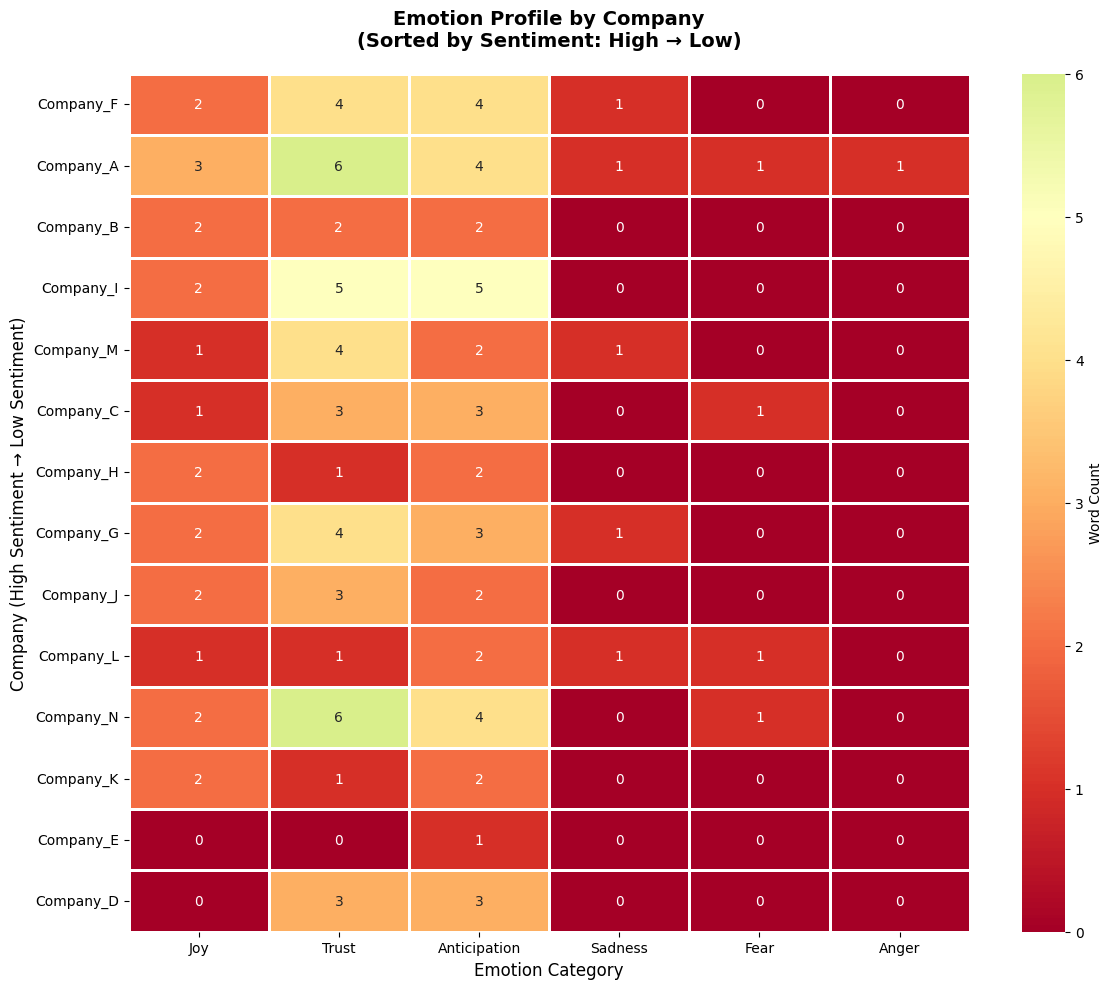

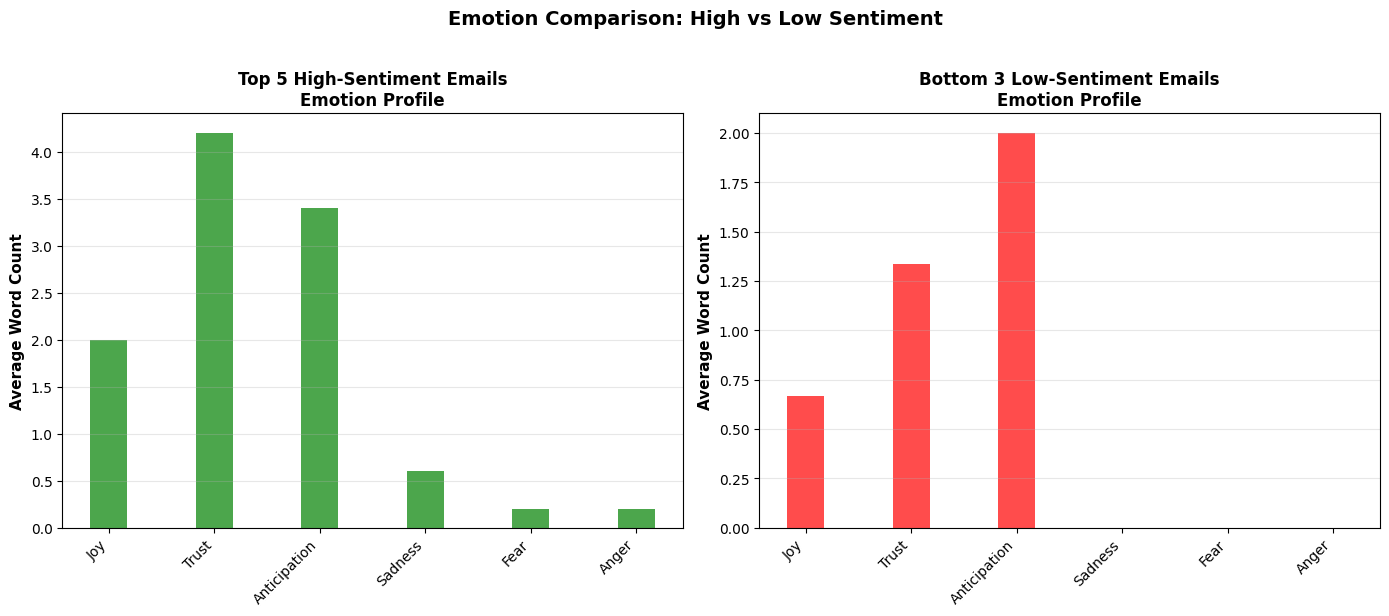

In [6]:
import numpy as np

df_plot = df[df['status'] != 'ghosted'].sort_values('vader_compound', ascending=False)

emotion_data = df_plot[['company_id'] + emotion_cols].set_index('company_id')
emotion_data.columns = [col.replace('emotion_', '').capitalize() for col in emotion_data.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_data, annot=True, fmt='.0f', cmap='RdYlGn', 
            center=5, linewidths=1, cbar_kws={'label': 'Word Count'})
plt.title('Emotion Profile by Company\n(Sorted by Sentiment: High → Low)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Company (High Sentiment → Low Sentiment)', fontsize=12)
plt.tight_layout()
plt.savefig('../visualizations/emotion_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Emotion comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

top_avg = top_5[emotion_cols].mean()
bottom_avg = bottom_3[emotion_cols].mean()

x = np.arange(len(emotion_cols))
width = 0.35

labels = [col.replace('emotion_', '').capitalize() for col in emotion_cols]

ax1.bar(x, top_avg, width, label='Top 5 (0.97-0.99)', color='green', alpha=0.7)
ax1.set_ylabel('Average Word Count', fontsize=11, fontweight='bold')
ax1.set_title('Top 5 High-Sentiment Emails\nEmotion Profile', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

ax2.bar(x, bottom_avg, width, label='Bottom 3 (0.31-0.89)', color='red', alpha=0.7)
ax2.set_ylabel('Average Word Count', fontsize=11, fontweight='bold')
ax2.set_title('Bottom 3 Low-Sentiment Emails\nEmotion Profile', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Emotion Comparison: High vs Low Sentiment', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../visualizations/emotion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:

print(f"Empathy words vs Joy emotion: {df['empathy_words'].corr(df['emotion_joy']):.3f}")

Empathy words vs Joy emotion: 0.653


In [8]:
# Check each empathy keyword
empathy_keywords = ['thank', 'appreciate', 'grateful', 'hope', 'wish', 'impressed']

print("Which empathy keywords trigger JOY in NRC?")
for word in empathy_keywords:
    if word in nrc_dict:
        emotions = nrc_dict[word]
        if 'joy' in emotions:
            print(f"✅ {word:12} → {emotions}")
        else:
            print(f"⚠️  {word:12} → {emotions} (no joy!)")
    else:
        print(f"❌ {word:12} → Not in NRC")

Which empathy keywords trigger JOY in NRC?
❌ thank        → Not in NRC
❌ appreciate   → Not in NRC
⚠️  grateful     → ['positive'] (no joy!)
✅ hope         → ['anticipation', 'joy', 'positive', 'surprise', 'trust']
❌ wish         → Not in NRC
❌ impressed    → Not in NRC


In [9]:
# Find all joy-triggering words in your dataset
print("\n" + "="*80)
print("WHAT WORDS ACTUALLY TRIGGER JOY IN YOUR EMAILS?")
print("="*80)

all_joy_words = {}

for idx, row in df[df['status'] != 'ghosted'].iterrows():
    text = row['email_text']
    if pd.notna(text):
        words = re.findall(r'\b[a-z]+\b', text.lower())
        
        for word in words:
            if word in nrc_dict and 'joy' in nrc_dict[word]:
                if word not in all_joy_words:
                    all_joy_words[word] = 0
                all_joy_words[word] += 1

print("\nMost frequent JOY-triggering words in rejection emails:")
for word, count in sorted(all_joy_words.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word:15} → appears {count} times")

print("\n" + "="*80)
print("Company F vs Company D - ACTUAL JOY WORDS:")
print("="*80)

# Check Company F
company_f_text = df[df['company_id'] == 'Company_F']['email_text'].iloc[0]
words_f = re.findall(r'\b[a-z]+\b', company_f_text.lower())
joy_words_f = [w for w in words_f if w in nrc_dict and 'joy' in nrc_dict[w]]

print(f"\nCompany F joy words: {set(joy_words_f)}")
print(f"Count: {len(joy_words_f)}")

# Check Company D
company_d_text = df[df['company_id'] == 'Company_D']['email_text'].iloc[0]
words_d = re.findall(r'\b[a-z]+\b', company_d_text.lower())
joy_words_d = [w for w in words_d if w in nrc_dict and 'joy' in nrc_dict[w]]

print(f"\nCompany D joy words: {set(joy_words_d)}")
print(f"Count: {len(joy_words_d)}")



WHAT WORDS ACTUALLY TRIGGER JOY IN YOUR EMAILS?

Most frequent JOY-triggering words in rejection emails:
good            → appears 4 times
luck            → appears 4 times
hope            → appears 3 times
encourage       → appears 3 times
happy           → appears 2 times
appreciation    → appears 1 times
proud           → appears 1 times
organization    → appears 1 times
finally         → appears 1 times
providing       → appears 1 times
journey         → appears 1 times

Company F vs Company D - ACTUAL JOY WORDS:

Company F joy words: {'happy', 'hope'}
Count: 2

Company D joy words: set()
Count: 0


#### Test: Does "Good Luck" Predict Sentiment?

In [10]:
# Check which companies say "good luck"
print("\n" + "="*80)
print("WHO SAYS 'GOOD LUCK'?")
print("="*80)

for idx, row in df[df['status'] != 'ghosted'].iterrows():
    text = row['email_text'].lower()
    has_good_luck = 'good luck' in text or ('good' in text and 'luck' in text)
    
    if has_good_luck:
        print(f"✅ {row['company_id']:12} → {row['vader_compound']:.3f}")
    else:
        print(f"❌ {row['company_id']:12} → {row['vader_compound']:.3f}")

# Calculate average sentiment with vs without "good luck"
with_good_luck = []
without_good_luck = []

for idx, row in df[df['status'] != 'ghosted'].iterrows():
    text = row['email_text'].lower() if pd.notna(row['email_text']) else ""
    
    if 'good' in text and 'luck' in text:
        with_good_luck.append(row['vader_compound'])
    else:
        without_good_luck.append(row['vader_compound'])

print(f"\n📊 RESULTS:")
print(f"With 'good luck':    {np.mean(with_good_luck):.3f} avg sentiment (n={len(with_good_luck)})")
print(f"Without 'good luck': {np.mean(without_good_luck):.3f} avg sentiment (n={len(without_good_luck)})")
print(f"Difference:          {np.mean(with_good_luck) - np.mean(without_good_luck):+.3f}")



WHO SAYS 'GOOD LUCK'?
❌ Company_A    → 0.989
✅ Company_B    → 0.988
❌ Company_C    → 0.974
❌ Company_D    → 0.307
❌ Company_E    → 0.863
❌ Company_F    → 0.990
❌ Company_G    → 0.944
✅ Company_H    → 0.968
❌ Company_I    → 0.984
❌ Company_J    → 0.931
✅ Company_K    → 0.886
❌ Company_L    → 0.931
❌ Company_M    → 0.980
❌ Company_N    → 0.901

📊 RESULTS:
With 'good luck':    0.947 avg sentiment (n=3)
Without 'good luck': 0.890 avg sentiment (n=11)
Difference:          +0.057


In [11]:
# Check joy word density for all companies

joy_analysis = []

for idx, row in df[df['status'] != 'ghosted'].iterrows():
    text = row['email_text'].lower() if pd.notna(row['email_text']) else ""
    words = re.findall(r'\b[a-z]+\b', text)
    
    # Count joy words
    joy_words_found = [w for w in words if w in nrc_dict and 'joy' in nrc_dict[w]]
    
    # Check for "good luck"
    has_good_luck = 'good' in text and 'luck' in text
    
    joy_analysis.append({
        'company': row['company_id'],
        'sentiment': row['vader_compound'],
        'joy_count': len(joy_words_found),
        'joy_words': set(joy_words_found),
        'has_good_luck': has_good_luck,
        'word_count': row['word_count'],
        'joy_density': len(joy_words_found) / row['word_count'] if row['word_count'] > 0 else 0
    })

joy_df = pd.DataFrame(joy_analysis).sort_values('sentiment', ascending=False)

print("\nRanked by sentiment:")
print(f"{'Company':12} {'Sentiment':>10} {'Joy Count':>10} {'Joy Density':>12} {'Good Luck?':>12} {'Joy Words'}")
print("-" * 100)

for _, row in joy_df.iterrows():
    good_luck_marker = '✅' if row['has_good_luck'] else '❌'
    print(f"{row['company']:12} {row['sentiment']:10.3f} {row['joy_count']:10} {row['joy_density']:12.3f} {good_luck_marker:>12} {row['joy_words']}")

print("\n📊 CORRELATION ANALYSIS:")
print(f"Joy count vs sentiment:   {joy_df['joy_count'].corr(joy_df['sentiment']):.3f}")
print(f"Joy density vs sentiment: {joy_df['joy_density'].corr(joy_df['sentiment']):.3f}")


Ranked by sentiment:
Company       Sentiment  Joy Count  Joy Density   Good Luck? Joy Words
----------------------------------------------------------------------------------------------------
Company_F         0.990          2        0.012            ❌ {'happy', 'hope'}
Company_A         0.989          3        0.017            ❌ {'encourage', 'hope', 'appreciation'}
Company_B         0.988          2        0.014            ✅ {'luck', 'good'}
Company_I         0.984          2        0.015            ❌ {'encourage', 'proud'}
Company_M         0.980          1        0.009            ❌ {'encourage'}
Company_C         0.974          1        0.006            ❌ {'good'}
Company_H         0.968          2        0.023            ✅ {'luck', 'good'}
Company_G         0.944          2        0.018            ❌ {'happy', 'hope'}
Company_J         0.931          2        0.021            ❌ {'finally', 'organization'}
Company_L         0.931          1        0.014            ❌ {'luck'}
Compa

In [14]:
# Compare Company_K vs Company_F


company_k = df[df['company_id'] == 'Company_K'].iloc[0]
company_f = df[df['company_id'] == 'Company_F'].iloc[0]

print(f"\nCompany_K (0.886):")
print(f"  Word count:          {company_k['word_count']}")
print(f"  Joy words:           {company_k['emotion_joy']}")
print(f"  Empathy words:       {company_k['empathy_words']}")
print(f"  Personal pronouns:   {company_k['personal_pronouns']}")
print(f"  AFINN positive:      {company_k['afinn_positive_count']}")
print(f"  Apology words:       {company_k['apology_words']}")

print(f"\nCompany_F (0.990):")
print(f"  Word count:          {company_f['word_count']}")
print(f"  Joy words:           {company_f['emotion_joy']}")
print(f"  Empathy words:       {company_f['empathy_words']}")
print(f"  Personal pronouns:   {company_f['personal_pronouns']}")
print(f"  AFINN positive:      {company_f['afinn_positive_count']}")
print(f"  Apology words:       {company_f['apology_words']}")



Company_K (0.886):
  Word count:          47
  Joy words:           2
  Empathy words:       1
  Personal pronouns:   2
  AFINN positive:      4
  Apology words:       0

Company_F (0.990):
  Word count:          166
  Joy words:           2
  Empathy words:       5
  Personal pronouns:   15
  AFINN positive:      17
  Apology words:       1
